### 6. Graph manipulations, overfitting

In this project file, I explore additional graph models for the embedding:
1. A doubled graph with ~ twice as many nodes (one per edge)
2. An overfitted graph that uses subject's estimates as additional edges
3. A procrustes-minimized embedding per subject to simulate an additional distortion or bias.

In [1]:
# Graph creation based on pixel position

import numpy as np
import networkx as nx 

# Pixel positions in "warren ground truth positions.png"
image_points = np.array([
    [133,909],[57,909],[61,779],[377,777],[403,669],
    [517,667],[553,511],[559,309],[663,245],[663,59],
    [785,59],[787,119],[53,59],[305,319],[185,313],
    [403,961],[183,1143],[100,1081],[481,1137],[579,1117],
    [705,521],[911,341],[1049,345],[1025,543],[1041,751],
    [919,931],[709,919],[653,723],[733,625],[879,637],
    [871,755],[1017,213],[1019,63],[897,61],[897,99],
    [1165,61],[1165,1165],[1005,1167],[861,1065],[847,1165],
    [781,1163],[595,607]
    ])

n = image_points.shape[0]

gt = image_points.astype(float)

offset = gt[0]
refLength = np.linalg.norm(gt[1]-gt[0])
gt = (gt-offset)/refLength*[1,-1] # Image coordinate to euclidean xy correction

# for exact measurements of wormhole1's entrance
wh1_entrances = np.array([[61,559],[557,57]],float)
wh1_entrances = (wh1_entrances-offset)/refLength*[1,-1] 

# 2 versions: Gn - no wormhole | Gw - wormhole
Gn = nx.Graph()
Gw = nx.Graph()
Gn.add_nodes_from(range(n))
Gw.add_nodes_from(range(n))

Gn.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,12),(9,12),(32,35),(35,36),(36,37)    # WH-related edges
    ])

Gw.add_edges_from([
    (0,1),(1,2),(2,3),(3,4),(3,15),(4,5),(4,13),(5,41),(6,7),(6,41),
    (7,8),(8,9),(9,10),(10,11),(13,14),(15,16),(15,18),(16,17),(18,19),
    (20,21),(20,41),(21,22),(21,31),(22,23),(23,24),(24,25),(25,26),(25,38),
    (26,27),(27,41),(28,29),(28,41),(29,30),(31,32),(32,33),(33,34),(37,38),(38,39),
    (39,40),
    (2,9),(32,36),(36,37)  # WH-related edges
    ])


# exact distances
D = np.zeros((n,n))
for u,v in Gn.edges:
    D[u,v]=np.linalg.norm(gt[u]-gt[v])
    D[v,u]=np.linalg.norm(gt[u]-gt[v])
D[2,9] = D[9,2] = np.linalg.norm(gt[2]-wh1_entrances[0])\
    +np.linalg.norm(gt[9]-wh1_entrances[1])
D[32,36] = D[36,32] = D[32,35]

#triplets, exact angles
Tn = []
Tw = []
A = np.zeros((n, n, n),float)
for i in range(n):
    for j in range(n):
        for k in range(n):
            if Gn.has_edge(i,j) and Gn.has_edge(j,k):
                Tn.append([i,j,k])
                A[i,j,k] = np.math.atan2(np.linalg.det([gt[j]-gt[i], gt[j]-gt[k]]),
                    np.dot(gt[j]-gt[i], gt[j]-gt[k]))
            if Gw.has_edge(i,j) and Gw.has_edge(j,k):
                Tw.append([i,j,k])
Tn = np.asarray(Tn)
Tw = np.asarray(Tw)

# Wormhole angle changes
A[1,2,9] = A[1,2,12]
A[9,2,1] = A[12,2,1]
A[3,2,9] = A[3,2,12]
A[9,2,3] = A[12,2,3]
A[2,9,8] = A[12,9,8]
A[8,9,2] = A[8,9,12]
A[2,9,10] = A[12,9,10]
A[10,9,2] = A[10,9,12]

A[31,32,36] = A[31,32,35]
A[36,32,31] = A[35,32,31]
A[32,36,37] = A[35,36,37]
A[37,36,32] = A[37,36,35]
A[33,32,36] = A[33,32,35]
A[36,32,33] = A[35,32,33]

Gw.remove_node(12)
Gw.remove_node(35)

# Object positions
O = {
    "bookcase":0,
    "cactus":11,
    "clock":14,
    "earth":17,
    "flamingo":19,
    "gear":23,
    "moon":30,
    "well":34,
    "sink":40
}

In [2]:
# "Double" graph with an additional node per edge. Uses suffix Gd.

Gd = Gw.copy()
nd = n+Gw.number_of_edges()
i = n # index for new nodes

gt = np.pad(gt,((0,Gw.number_of_edges()),(0,0)))

for e in Gd.copy().edges():
    u,v=e
    Gd.remove_edge(u,v)
    Gd.add_node(i)
    Gd.add_edges_from([(u,i),(i,v)])
    gt[i]=(gt[u]+gt[v])/2
    i+=1

Dd = np.zeros((nd,nd))
for u,v in Gd.edges:
    Dd[u,v]=np.linalg.norm(gt[u]-gt[v])
    Dd[v,u]=np.linalg.norm(gt[u]-gt[v])
#Wormhole distance fix
Dd[2,45] = Dd[45,2] = Dd[45,9] = Dd[9,45] = D[2,9]/2
Dd[32,78] = Dd[78,32] = Dd[78,36] = Dd[36,78] = D[32,35]/2

Td=[]
Ad = np.zeros((nd,nd,nd),float)
for i in range(nd):
    for j in range(nd):
        for k in range(nd):
            if Gd.has_edge(i,j) and Gd.has_edge(j,k):
                Td.append([i,j,k])
                Ad[i,j,k] = np.math.atan2(np.linalg.det([gt[j]-gt[i], gt[j]-gt[k]]),
                    np.dot(gt[j]-gt[i], gt[j]-gt[k]))
Td = np.asarray(Td)

# Wormhole angle changes
Ad[43,2,45] = A[1,2,9]
Ad[45,2,43] = A[9,2,1]
Ad[44,2,45] = A[3,2,9]
Ad[45,2,44] = A[9,2,3]
Ad[45,9,54] = A[2,9,8]
Ad[54,9,45] = A[8,9,2]
Ad[45,9,55] = A[2,9,10]
Ad[55,9,54] = A[10,9,2]

Ad[76,32,78] = A[31,32,36]
Ad[78,32,76] = A[36,32,31]
Ad[78,36,80] = A[32,36,37]
Ad[80,36,78] = A[37,36,32]
Ad[77,32,78] = A[33,32,36]
Ad[78,32,77] = A[36,32,33]

For the overfitting graph, subject estimates are assumed to be additional edges in the graph with corresponding angles. The distance is unknown and is inferred from vector addition along the shortest path:

In [3]:
# Overfitting the graph based on the average measurements in data_wh1:
import function_repository4 as fr4
import scipy.stats


def dataPerSubject(data, s):
    """Importer function to extract a line from Warren's data"""

    dataPS = [
        [O["cactus"], O["bookcase"], data[s, 0]],
        [O["bookcase"], O["cactus"], data[s, 1]],
        [O["well"], O["sink"], data[s, 2]],
        [O["sink"], O["well"], data[s, 3]],
        [O["clock"], O["earth"], data[s, 4]],
        [O["earth"], O["clock"], data[s, 5]],
        [O["moon"], O["flamingo"], data[s, 6]],
        [O["flamingo"], O["moon"], data[s, 7]]
    ]

    for d in dataPS:
        # transform angular differences into global angles
        d[2] = np.deg2rad(d[2])+fr4.angle(gt[d[0]], gt[d[1]])

    return dataPS


# import subject data
data = np.loadtxt("datasets/data_wh1.txt",
                  delimiter='\t', skiprows=1, dtype=float)
# correction for mirrored angles due to warren dataset
data[:, 0] *= -1
data[:, 3:] *= -1

data_avg = scipy.stats.circmean(data, -np.pi, np.pi, axis=0)
data_avg = dataPerSubject(np.expand_dims(data_avg,axis=0), 0)

Go = Gw.copy()
To = Tw.copy()

for i in range(4):
    u = data_avg[2*i][0]
    v = data_avg[2*i][1]
    nbr_u = [nbr for nbr in Gw[u]][0]
    nbr_v = [nbr for nbr in Gw[v]][0]
    Go.add_edge(u, v)
    path_uv = nx.dijkstra_path(Gw, u, v)
    v_uv = fr4.vectorAlongPath(path_uv, gt, D, A)
    D[u, v] = D[v, u] = np.linalg.norm(v_uv)
    A[nbr_u, u, v] = data_avg[2*i][2] - fr4.angle(gt[u], gt[nbr_u])
    A[nbr_v, v, u] = data_avg[2*i+1][2] - fr4.angle(gt[v], gt[nbr_v])
    To = np.append(To, [[nbr_u, u, v]], axis=0)
    To = np.append(To, [[nbr_v, v, u]], axis=0)


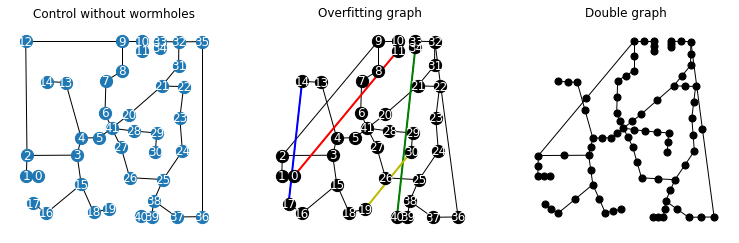

In [5]:
# [RUN TWICE for large plots!] The graphs with ther nodes at the respective pixel
# positions (gt)

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [13, 5]

ax = plt.subplot(131, aspect='equal')
nx.draw(Gn, with_labels=True, node_size=150, pos=gt, font_color='w')
ax.set_title("Control without wormholes")

ax = plt.subplot(132, aspect='equal')
plt.plot([gt[0][0], gt[11][0]], [gt[0][1], gt[11][1]], color='r', linewidth=2)
plt.plot([gt[14][0], gt[17][0]], [gt[14][1], gt[17][1]], color='b', linewidth=2)
plt.plot([gt[34][0], gt[40][0]], [gt[34][1], gt[40][1]], color='g', linewidth=2)
plt.plot([gt[19][0], gt[30][0]], [gt[19][1], gt[30][1]], color='y', linewidth=2)
nx.draw(Go, with_labels=True, node_size=150,
        pos=gt, node_color='k', font_color='w')
ax.set_title("Overfitting graph")

ax = plt.subplot(133, aspect='equal')
nx.draw(Gd, with_labels=False, node_size=50,
        pos=gt, node_color='k', font_color='w')
ax.set_title("Double graph")

plt.show()


I have not yet attempted to find different minimal embeddings for these graphs. The results below are based on the random seeds for the regular embedding.

In [6]:
# Find embeddings based on a fixed random seed, as in the other files.
import scipy.optimize

# Node 0 is constrained to (0,0)
cons = ({'type': 'eq', 'fun': lambda x: x[0]},
        {'type': 'eq', 'fun': lambda x: x[1]})

np.random.seed(3773)
x0 = np.random.uniform(size=(n, 2))
sl1 = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, D, A, Tw),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Default embedding - Iterations: {}, stress: {}".format(sl1.nit, sl1.fun))
em1 = sl1.x.reshape(n, 2)

np.random.seed(3773)
x0 = np.random.uniform(size=(n, 2))
slo = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, D, A, To),
                              method='SLSQP', constraints=cons, options={'maxiter': 500})
print("Overfit embedding - Iterations: {}, stress: {}".format(slo.nit, slo.fun))
emo = slo.x.reshape(n, 2)

np.random.seed(3773)
x0 = np.random.uniform(size=(nd, 2))
sld = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, Dd, Ad, Td),
                              method='SLSQP', constraints=cons, options={'maxiter': 2000})
print("Double graph embedding - Iterations: {}, stress: {}".format(sld.nit, sld.fun))
emd = sld.x.reshape(nd, 2)


Default embedding - Iterations: 154, stress: 450.6799883152159
Overfit embedding - Iterations: 148, stress: 465.07829401792173
Double graph embedding - Iterations: 434, stress: 19.497213365992522


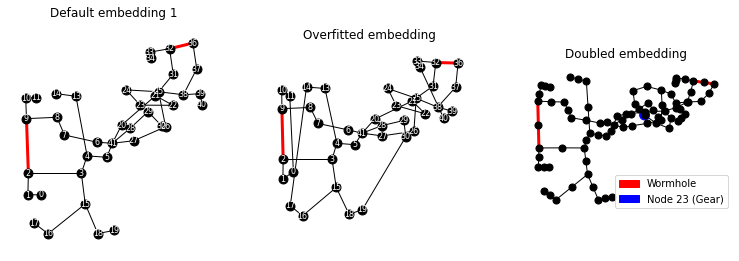

In [7]:
# Rotate and plot the embeddings
import matplotlib.patches

r1 = fr4.angle(em1[2], em1[3])
em1 = em1@np.array([[np.cos(r1), -np.sin(r1)], [np.sin(r1), np.cos(r1)]])

r2 = fr4.angle(emo[2], emo[3])
emo = emo@np.array([[np.cos(r2), -np.sin(r2)], [np.sin(r2), np.cos(r2)]])

r3 = fr4.angle(emd[2], emd[3])
emd = emd@np.array([[np.cos(r3), -np.sin(r3)], [np.sin(r3), np.cos(r3)]])


ax = plt.subplot(131, aspect='equal')
plt.plot([em1[2][0], em1[9][0]], [em1[2][1],
         em1[9][1]], color='r', linewidth=3)
plt.plot([em1[32][0], em1[36][0]], [em1[32][1],
         em1[36][1]], color='r', linewidth=3)
nx.draw(Gw, with_labels=True, node_size=80, pos=em1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Default embedding 1")


ax = plt.subplot(132, aspect='equal')
plt.plot([emo[2][0], emo[9][0]], [emo[2][1],
         emo[9][1]], color='r', linewidth=3)
plt.plot([emo[32][0], emo[36][0]], [emo[32][1],
         emo[36][1]], color='r', linewidth=3)
nx.draw(Go, with_labels=True, node_size=80, pos=emo, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Overfitted embedding")


lw = matplotlib.patches.Patch(color='r', label="Wormhole")
l23 = matplotlib.patches.Patch(color='b', label="Node 23 (Gear)")

ax = plt.subplot(133, aspect='equal')
plt.plot([emd[2][0], emd[9][0]], [emd[2][1],
         emd[9][1]], color='r', linewidth=3)
plt.plot([emd[32][0], emd[36][0]], [emd[32][1],
         emd[36][1]], color='r', linewidth=3)
nx.draw(Gd, with_labels=False, node_size=50, pos=emd, node_color='k', font_size=8,
        font_color='w')
ax.add_patch(plt.Circle(emd[23], radius=0.45, color='b'))
ax.legend(handles=[lw, l23])
ax.set_title("Doubled embedding")
plt.show()


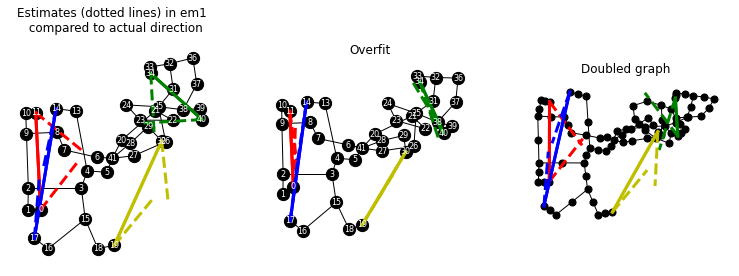

In [8]:
# Example: Average estimate

est_local1 = fr4.makeLocal(Gw, gt, em1, data_avg)
est_localo = fr4.makeLocal(Go, gt, emo, data_avg)
est_locald = fr4.makeLocal(Gd, gt, emd, data_avg)

estimate_colors = ['r', 'r', 'g', 'g', 'b', 'b', 'y', 'y']

ax = plt.subplot(131, aspect='equal')
nx.draw(Gw, with_labels=True, node_size=150, pos=em1, node_color='k', font_size=8,
        font_color='w')
ax.set_title("Estimates (dotted lines) in em1 \n compared to actual direction")
for d, c in zip(est_local1, estimate_colors):
    fr4.plotLineAndMeasurement(d, em1, c, 3)

ax = plt.subplot(132, aspect='equal')
nx.draw(Go, with_labels=True, node_size=150, pos=emo, node_color='k', font_size=8,
        font_color='w')
ax.set_title(
    "Overfit")
for d, c in zip(est_localo, estimate_colors):
    fr4.plotLineAndMeasurement(d, emo, c, 3)

ax = plt.subplot(133, aspect='equal')
nx.draw(Gd, with_labels=False, node_size=50, pos=emd, node_color='k', font_size=8,
        font_color='w')
ax.set_title(
    "Doubled graph")
for d, c in zip(est_locald, estimate_colors):
    fr4.plotLineAndMeasurement(d, emd, c, 3)


#### 6.1 Statistics - Doubled graph

In the plot, the prediction by the doubled graph seems a bit better than embedding 1. 
Do statistical tests agree?

In [9]:
# Create data over all subjects

def angularError(m, vec, ed=1):
    """
    Maybe the error that was used by Warren 2017. Who knows?
    ed = 1/-1 is the direction in which the error increases, as in Warren2017
    """
    a = m[2]
    b = np.arctan2(vec[1], vec[0])
    smaller_angle = (a-b+np.pi) % (2*np.pi)-np.pi
    return ed*smaller_angle


leftRightIncrease = [-1, 1, 1, -1, -1, -1, -1, -1]

# Create a dataset over all subjects (n=10, 8 tests in 3 envs. each -> 10x24 table)

dataset_ae = []

for s in range(len(data)):
    data_sub = dataPerSubject(data, s)
    est_local1 = fr4.makeLocal(Gw, gt, em1, data_sub)
    est_locald = fr4.makeLocal(Gd, gt, emd, data_sub)

    ae_vectorAddition = []
    for ed, m in zip(leftRightIncrease, data_sub):
        v = fr4.vectorAlongPath(nx.dijkstra_path(Gw, m[0], m[1]), gt, D, A)
        ae_vectorAddition.append(angularError(m, v, ed))

    ae_em1 = []
    for ed, m in zip(leftRightIncrease, est_local1):
        v = em1[m[1]]-em1[m[0]]
        ae_em1.append(angularError(m, v, ed))

    ae_emd = []
    for ed, m in zip(leftRightIncrease, est_locald):
        v = emd[m[1]]-emd[m[0]]
        ae_emd.append(angularError(m, v, ed))

    dataset_ae.append(ae_vectorAddition+ae_em1+ae_emd)

dataset_ae = np.asarray(dataset_ae)
print("Dataset_ae shape: {}".format(dataset_ae.shape))

# [commented out to avoid acccidental overwriting] save the dataset
# np.savetxt("datasets/double_ae.txt", dataset_ae, delimiter="\t", fmt="%f")


Dataset_ae shape: (10, 24)


Results, overall average:
Avg. angular error: va: -12.4960° | em1: -15.2654° | double: -9.2297°
Avg. absolute angular error: va: 13.0551° | em1: 15.2654° | double: 11.0947°


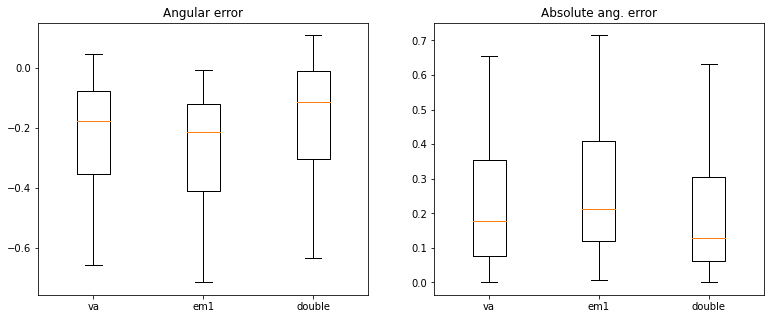

In [10]:
# Data formatting and boxplots

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

dataset_ae = np.loadtxt("datasets/double_ae.txt", delimiter="\t", dtype=float)

# all samples
# ae_va = dataset_ae[:, :8].flatten()
# ae_em1 = dataset_ae[:, 8:16].flatten()
# ae_emd = dataset_ae[:, 16:].flatten()

# Option: mean over all subjects
ae_va = scipy.stats.circmean(dataset_ae[:, :8], np.pi, -np.pi, axis=1)
ae_em1 = scipy.stats.circmean(dataset_ae[:, 8:16], np.pi, -np.pi, axis=1)
ae_emd = scipy.stats.circmean(dataset_ae[:, 16:], np.pi, -np.pi, axis=1)


print("Results, overall average:")


print("Avg. angular error: va: {:.4f}° | em1: {:.4f}° | double: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_va), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_em1), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_emd), np.pi, -np.pi))))

print("Avg. absolute angular error: va: {:.4f}° | em1: {:.4f}° | double: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(np.abs(np.asarray(ae_va)), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(
        np.abs(np.asarray(ae_em1)), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.abs(np.asarray(ae_emd)), np.pi, -np.pi))))


# Boxplot of the results
ax = plt.subplot(121)
ax.boxplot([ae_va, ae_em1, ae_emd])
ax.set_xticklabels(["va", "em1", "double"])
ax.set_title("Angular error")

ax = plt.subplot(122)
ax.boxplot([np.abs(ae_va), np.abs(ae_em1), np.abs(ae_emd)])
ax.set_xticklabels(["va", "em1", "double"])
ax.set_title("Absolute ang. error")
plt.show()


In [11]:
# Angular error tests
import pycircstat
import function_repository4 as fr4

print("Ang. error double:")
ww_p, _ = pycircstat.tests.watson_williams(ae_va, ae_emd)
print("Wattson-Williams result: p={}".format(ww_p))
print(scipy.stats.ttest_ind(ae_va, ae_emd, equal_var=False))
print(scipy.stats.mannwhitneyu(ae_va, ae_emd))
print(scipy.stats.kstest(ae_va, ae_emd))
print("Cohen's d (VA-em1): {}, Circular: {}".format(fr4.cohens_d(ae_va, ae_emd), 
    fr4.cohens_d(ae_va, ae_emd, circular=True)))



Ang. error double:
Wattson-Williams result: p=0.5699503581813119
Ttest_indResult(statistic=-0.5741192698511295, pvalue=0.5730042523604766)
MannwhitneyuResult(statistic=40.0, pvalue=0.47267559351158717)
KstestResult(statistic=0.2, pvalue=0.9944575548290717)
Cohen's d (VA-em1): -0.25675394291593423, Circular: -0.26376614866774567


The results in the doubled graph seem to be a bit better, but any differences are not significant. I.e., there is no need to continue analyses with larger graphs.

<br />

#### 6.2 Statistics - overfit

In the following, I will demonstrate that it is possible to find an overfit for each subject's estimates by using the data as additional edges in the graph and feeding this graph to the Hübner & Mallot algorithm.

Unfortunately, cross-validation between the shortcut and rips-and-folds datasets is not possible, since the measurements come from separate events with different subjects. And for cross-validation within the same set the estimates are too far apart - fitting one estimate has only a minor influence on the rest of the graph.

In [12]:
# Find an overfit for each subject and generate error data

dataset_ae = []

for i in range(len(data)):

    data_sub = dataPerSubject(data, i)

    # update graph labels according to the subject's estimates
    for j in range(4):
        u = data_sub[2*j][0]
        v = data_sub[2*j][1]
        nbr_u = [nbr for nbr in Gw[u]][0]
        nbr_v = [nbr for nbr in Gw[v]][0]
        path_uv = nx.dijkstra_path(Gw, u, v)
        v_uv = fr4.vectorAlongPath(path_uv, gt, D, A)
        D[u, v] = D[v, u] = np.linalg.norm(v_uv)
        A[nbr_u, u, v] = data_sub[2*j][2] - fr4.angle(gt[u], gt[nbr_u])
        A[nbr_v, v, u] = data_sub[2*j+1][2] - fr4.angle(gt[v], gt[nbr_v])

    np.random.seed(3773)
    x0 = np.random.uniform(size=(n, 2))
    slo = scipy.optimize.minimize(fr4.fast_stress, x0.flatten(), (1, 1, D, A, To),
        method='SLSQP', constraints=cons, options={'maxiter': 500})
    emo = slo.x.reshape(n, 2)

    est_localo = fr4.makeLocal(Gw, gt, emo, data_sub)

    # ax = plt.subplot(121, aspect='equal')
    # nx.draw(Gw, with_labels=True, node_size=150, pos=emo, node_color='k', font_size=8,
    #         font_color='w')
    # ax.set_title(
    #     "Estimates (dotted lines) in overfit \n compared to actual direction")
    # for d, c in zip(est_localo, estimate_colors):
    #     fr4.plotLineAndMeasurement(d, emo, c, 3)
    # plt.show()

    ae_emo = []
    for ed, m in zip(leftRightIncrease, est_localo):
        v = emo[m[1]]-emo[m[0]]
        ae_emo.append(angularError(m, v, ed))

    dataset_ae.append(ae_emo)

    print("{}/{}, Mean err.: {:.4f}°".format(i+1,
          data.shape[0], np.rad2deg(scipy.stats.circmean(ae_emo))), end="\r")

dataset_ae = np.asarray(dataset_ae)
print("\nDataset_ae shape: {}".format(dataset_ae.shape))


10/10, Mean err.: 359.3867°
Dataset_ae shape: (10, 8)


Results, overall average:
Avg. angular error: va: -12.4960° | overfit: -2.2197°
Avg. absolute angular error: va: 13.0551° | overfit: 2.2197°


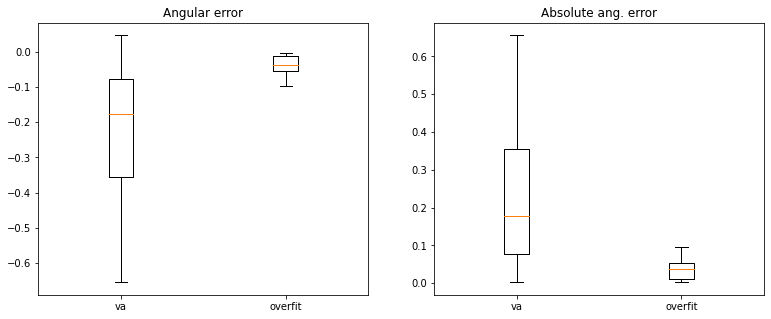

Circular variance va:0.042092761942587875, Overfit:0.0008739592703912771
Wattson-Williams result: p=0.01792771640049202

Shapiro-Wilk-test for normal distribution: va, Overfit
ShapiroResult(statistic=0.9396512508392334, pvalue=0.5491392612457275)
ShapiroResult(statistic=0.9354588389396667, pvalue=0.5036730170249939)
Ttest_indResult(statistic=-2.6118269807653074, pvalue=0.017654612355106538)
Cohen's d (VA-em1): -1.1680445348918527, Circular: -0.8298462762531693


In [13]:
# [Comment in plotting!] Formatting, boxplots and significance testing

# [commented out to avoid acccidental overwriting] save the dataset
# np.savetxt("datasets/overfit_ae.txt", dataset_ae, delimiter="\t", fmt="%f")

dataset_ae = np.loadtxt("datasets/dataset_ae.txt", delimiter="\t", dtype=float)
overfit_ae = np.loadtxt("datasets/overfit_ae.txt", delimiter="\t", dtype=float)

# all samples
# ae_va = dataset_ae[:, :8].flatten()
# ae_of = overfit_ae.flatten()

ae_va = scipy.stats.circmean(dataset_ae[:, :8], np.pi, -np.pi, axis=1)
ae_of = scipy.stats.circmean(overfit_ae, np.pi, -np.pi, axis=1)

print("Results, overall average:")
print("Avg. angular error: va: {:.4f}° | overfit: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_va), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.asarray(ae_of), np.pi, -np.pi))))

print("Avg. absolute angular error: va: {:.4f}° | overfit: {:.4f}°".format(
    np.rad2deg(scipy.stats.circmean(np.abs(np.asarray(ae_va)), np.pi, -np.pi)),
    np.rad2deg(scipy.stats.circmean(np.abs(np.asarray(ae_of)), np.pi, -np.pi))))

# Boxplot of the results
ax = plt.subplot(121)
ax.boxplot([ae_va, ae_of])
ax.set_xticklabels(["va", "overfit"])
ax.set_title("Angular error")

ax = plt.subplot(122)
ax.boxplot([np.abs(ae_va), np.abs(ae_of)])
ax.set_xticklabels(["va", "overfit"])
ax.set_title("Absolute ang. error")
plt.show()

# significance testing
import pycircstat

print("Circular variance va:{}, Overfit:{}".format(
    scipy.stats.circvar(ae_va, np.pi, -np.pi),
    scipy.stats.circvar(ae_of, np.pi, -np.pi)))

ww_p, _ = pycircstat.tests.watson_williams(ae_va, ae_of)
print("Wattson-Williams result: p={}".format(ww_p))

# t-tests should also work given that the errors cluster around 0 and range from -pi to pi
print("\nShapiro-Wilk-test for normal distribution: va, Overfit")
print(scipy.stats.shapiro(ae_va))
print(scipy.stats.shapiro(ae_of))

print(scipy.stats.ttest_ind(ae_va, ae_of))
print("Cohen's d (VA-em1): {}, Circular: {}".format(fr4.cohens_d(ae_va, ae_of), 
    fr4.cohens_d(ae_va, ae_of, circular=True)))


<br />

#### 6.3 Discussion

The assumption behind the minimization of angular differences with the Hübner & Mallot algorithm is that subject errors are distributed around the true values. This seems to be a reasonable assumption given the model is comparable to the vector addition prediction that was proposed by Warren et al. 

This type of embedding has an upper limit (which would be reached at an embedding stress/error of 0), which is probably why there isn't much of an increase with more nodes. On the other hand, it cannot account for inter-subject variability without knowing the true angle and distance measurements for each subject.

At least for the estimates presented here, nearly perfect embeddings exist, which can be obtained by overfitting the graph to the subject data. With the overfits, I do **not** want to imply that the embeddings reflect the true shape of each subject's cognitive map. Rather, I want to show that such embeddings may exist in princpile, given enough individual measurements. Of course, the overfits also don't mean that the vector addition model is wrong; after all, vector addition based on the overfits would produce exactly the same results.

It might also be the case that an embedding reflecting every subjective measurement does not exist: At least in the rips and folds experiment, the algorithm is unable to find a satisfactory position for the nodes around the "Gear" landmark that minimizes the error between subject estimations and prediction (but I haven't tried to overfit it yet).

<br />

### 7. Overall discussion

In this project, I used data from an experiment by Warren et al. (2017) to propose and verify a distorted euclidean embedding for a non-euclidean maze. In the VR maze, two wormholes instantly and seamlessly transported participants to distant parts while they had to learn landmark positions. Later, the participants had to recall target objects by directly walking to them without maze walls (so-called shortcuts).

Because the estimates heavily deviate from the Euclidean ground truth position of the objects towards the wormholes, Warren et al. rejected a Euclidean representation in favor of a *labeled graph*, a topological model with local position information. In the model, shortcuts are found by vector addition along the shortest path, which leads to biased estimates if the shortest path goes through a wormhole.

The authors also briefly consider the possibilty of a distorted Euclidean map where locations around the wormholes are *"pinched together"*, but reject the option due to apparent violation of the positivity principle (e.g., the same landmark occupying different positions when approached from different directions).

However, the argument assumes that such violations are actually detected by the subjects (they apparently are not) and ignores the possibility of measurement errors (i.e., distortions are assumed to be a measurement mistake by the participant). 

Here I show a method to obtain such distorted Euclidean embeddings by minimizing the local angles and distances (the labels of the labeled graph), using a dot product fitting algorithm proposed by Hübner & Mallot (2007). Interestingly, without any individual fitting to participant data, these embeddings already make predictions at least as good as those of the labeled graph model. I therefore argue that a Euclidean cognitive map cannot be rejected by the findings of Warren et al.

Of course, a distorted Euclidean embedding is still Euclidean and therefore does not violate metric postulates. The positivity violations reported by Warren et al. are only apparent under the ground truth model, i.e., when navigate between the actual postions of the landmarks rather than the distorted positions. Also, any perceived differences between path integration and the distorted map could simply be overwritten by visual position information and therefore never cause mismatch.

Finally, I show that it is also possible to distort the embeddings in a way that creates minimal error to the subject estimates by overfitting the model to the measurements. That is, there may exist an embedding for each participant that corresponds to the true cognitive map (this argument assumes that the measurement averages reflect the true underlying distribution), but to confirm this, many more individual measurements would be required. This is not an argument for the Euclidean embedding rather than the topological graph, because the same is true for the graph. It would be interesting to see how the embeddings compare to sketch maps. Notably, Warren et al. report that the sketch maps did not contain any crossings of maze arms, which differs from the distorted embeddings, so perhaps the fitting algorithm should be adjusted accordingly.

### 8. Conclusion

In summary, it remains unclear whether the cognitive map is euclidean or graph-like or both. In fact, there can never be an argument against the graph model but in favor of a Euclidean map, because it should always possible to construct a graph of any given embedding.

To find the embeddings presented here, it was necessary to make substantial assumptions about the underlying data, graph models (e.g., number of nodes and edges) and subject differences (e.g., assumed north). It is certainly possible that the embeddings would be completely unrecognizable to the participants of the experiment. But the predictions that can be made are at least as good as the predictions resulting from the labeled graph model, and can therefore refute the argument by Warren et al. A Euclidean metric cognitive map may exist after all.